In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
import os
import pickle
from pathlib import Path

import re
import matplotlib.patches as mpatches
import scipy.linalg as la
from scipy.stats import norm

from typing import Optional, Dict, Tuple, Any
from Plotting_helpers import*


# Original Set up Across Scenarios ( BB,NB, BN)

In [2]:

def tau_to_str(tau):
    return str(int(round(float(tau) * 10))).zfill(2)

def load_seed_outputs_simple(base_path,tau_levels,train_seeds,test_seeds,folder_template,filename_template,     
    verbose=True,):
    # load  ans save to tau-train-test seed nested dictionary
    base_path = Path(base_path)

    df = {}
    found_paths = {}

    for tau in tau_levels:
        tau_str = tau_to_str(tau)
        df[tau_str] = {}
        found_paths[tau_str] = {}

        for train_seed in train_seeds:
            df[tau_str][train_seed] = {}
            found_paths[tau_str][train_seed] = {}

            folder_name = folder_template.format(seed=train_seed, tau_str=tau_str)

            for test_seed in test_seeds:
                filename = filename_template.format(test_seed=test_seed)
                fpath = base_path / folder_name / filename

                if not fpath.exists():
                    if verbose:
                        print(f"Missing: {fpath}")
                    continue

                with open(fpath, "rb") as fh:
                    payload = pickle.load(fh)

                df[tau_str][train_seed][test_seed] = payload
                found_paths[tau_str][train_seed][test_seed] = str(fpath)

    return df, found_paths


#### Setting up seeds, tau levels and path to invoke the data

In [3]:
# Example usage:
tau_levels = [0.1, 0.5, 0.9]
train_seeds = [53, 274, 1234, 89]
test_seeds = [1, 2, 3, 4]
# path_run20260208_bull_bear_53_01
base_path = r"C:/Users/Attila/Desktop/Attila/Job/Q2C/Chapter2_model_comperison/Chapter2_model_comperison/training_outcome"

df, paths = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260209_neutral_bear_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
    verbose=True,
)


In [4]:
df['01'][53][1].keys() # policy, training seed, test seed and keys

dict_keys(['seed', 'T_days', 'burn_in_months', 'start_date', 'use_mean_action', 'dates', 'log_returns', 'h_days', 'regime_days', 'regime_month', 'sample_months', 'port_ret_gross', 'port_ret_net', 'turnover', 'fee', 'utility_reward', 'critic', 'weights'])

In [5]:
# open the files what you wanna compare
# Dirichlet_final_bull_bear_

tau_levels = [0.1, 0.5, 0.9]
train_seeds = [53, 274, 1234, 89]
test_seeds = [1, 2, 3, 4]
# path_run20260208_bull_bear_53_01
# path_run20260209_bull_bear
# path_run20260212
# path_run20260213_c001_new
# path_run20260213_c001: was ok

base_path = r"C:/Users/Attila/Desktop/Attila/Job/Q2C/Chapter2_model_comperison/Chapter2_model_comperison/training_outcome"

nested_bull_bear, found_paths_bull_bear = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260213_c001_new_bull_bear_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
)
nested_bull_neutral, found_paths_bull_neutral = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260213_c001_new_bull_neutral_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
)

nested_neutral_bear, found_paths_neutral_bear = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260213_c001_new_neutral_bear_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
    verbose=True,
)



In [6]:
# Average over train seeds + test seeds per tau policy
# Rp_net = max(Rp_gross - fee, 1e-8), port_ret_net[t] = Rp_net - 1.0
def average_policy_outputs(
    nested,
    return_key="port_ret_net",
    weight_key="weights",
    min_length=True,
    verbose=True,
):

    def _get_series(payload):
        if not isinstance(payload, dict):
            return None, None
        r = payload.get(return_key, None)
        if r is None:
            return None, None
        r = np.asarray(r, dtype=float)
        w = payload.get(weight_key, None)
        w = None if w is None else np.asarray(w, dtype=float)
        return r, w

    out = {}

    for tau_str, by_train_seed in (nested or {}).items():
        returns_list = []
        weights_list = []

        if not isinstance(by_train_seed, dict):
            if verbose:
                print(f"[warn] tau={tau_str}: expected dict[tau][train_seed][test_seed], got {type(by_train_seed)}")
            continue

        for train_seed, by_test_seed in by_train_seed.items():
            if not isinstance(by_test_seed, dict):
                if verbose:
                    print(f"[warn] tau={tau_str}, train_seed={train_seed}: expected dict of test_seeds, got {type(by_test_seed)}")
                continue

            for test_seed, payload in by_test_seed.items():
                r, w = _get_series(payload)
                if r is None:
                    continue
                returns_list.append(r)
                if w is not None:
                    weights_list.append(w)

        if not returns_list:
            if verbose:
                print(f"[warn] tau={tau_str}: no return series found")
            continue

        # align lengths
        if min_length:
            r_len = min(arr.shape[0] for arr in returns_list)
            returns_stack = np.stack([arr[:r_len] for arr in returns_list], axis=0)
        else:
            r_len = returns_list[0].shape[0]
            if any(arr.shape[0] != r_len for arr in returns_list):
                raise ValueError(f"tau={tau_str}: return series have different lengths; set min_length=True to trim.")
            returns_stack = np.stack(returns_list, axis=0)

        avg_returns = returns_stack.mean(axis=0)

        if weights_list:
            if min_length:
                w_len = min(arr.shape[0] for arr in weights_list)
                weights_stack = np.stack([arr[:w_len] for arr in weights_list], axis=0)
            else:
                w_len = weights_list[0].shape[0]
                if any(arr.shape[0] != w_len for arr in weights_list):
                    raise ValueError(f"tau={tau_str}: weight series have different lengths; set min_length=True to trim.")
                weights_stack = np.stack(weights_list, axis=0)
            avg_weights = weights_stack.mean(axis=0)
        else:
            w_len = 0
            avg_weights = None
        # average over the stacked returns and weights--> n_path,days--> daily average
        out[tau_str] = {
            "avg_returns": avg_returns,
            "avg_weights": avg_weights,
            "n_paths": int(len(returns_list)),
            "return_length": int(r_len),
            "weight_length": int(w_len),
        }

    return out


# Example usage
avg_bull_bear = average_policy_outputs(nested_bull_bear)
avg_bull_neutral = average_policy_outputs(nested_bull_neutral)
avg_neutral_bear = average_policy_outputs(nested_neutral_bear)

In [7]:
# Make tables for portfolio performance (scenario x tau), not weighted, dont refer to it
def _build_scenario_table(avg_dict, scen, periods_per_year=252):
    portfolios = {}
    for tau_str, payload in avg_dict.items():
        r = payload.get("avg_returns", None)
        if r is None:
            continue
        portfolios[f"tau_{tau_str}"] = r
    table = make_table_for_portfolios(portfolios, periods_per_year=periods_per_year)
    table = table.T  # rows: tau, cols: stats
    table.insert(0, "Scenario", scen)
    table.insert(1, "Tau", table.index)
    return table.reset_index(drop=True)

scenario_map = {
    "BB": avg_bull_bear,
    "BN": avg_bull_neutral,
    "NB": avg_neutral_bear,
}

# Stacked table: BB, BN, NB under each other
tables_by_scenario = [] 
for scen, avg_dict in scenario_map.items():
    tables_by_scenario.append(_build_scenario_table(avg_dict, scen, periods_per_year=252))
stacked_portfolio_table = pd.concat(tables_by_scenario, ignore_index=True)
stacked_portfolio_table

# Separate tables (more visible per scenario)
bb_table = _build_scenario_table(avg_bull_bear, "BB", periods_per_year=252)
bn_table = _build_scenario_table(avg_bull_neutral, "BN", periods_per_year=252)
nb_table = _build_scenario_table(avg_neutral_bear, "NB", periods_per_year=252)


In [8]:
#bb_table,bn_table,nb_table,stacked_portfolio_table

In [9]:
'''
We need to argue that aggregate results can be misleading and we need to look 
per scenario and regime

'''

'\nWe need to argue that aggregate results can be misleading and we need to look \nper scenario and regime\n\n'

In [10]:
nested_bull_bear['01'][53].keys() # tau,train seed, test seed and keys

dict_keys([1, 2, 3, 4])

In [11]:
nested_bull_bear['01'][53][1].keys()

dict_keys(['seed', 'T_days', 'burn_in_months', 'start_date', 'use_mean_action', 'dates', 'log_returns', 'h_days', 'regime_days', 'regime_month', 'sample_months', 'port_ret_gross', 'port_ret_net', 'turnover', 'fee', 'utility_reward', 'critic', 'weights'])

In [12]:
# regime_key - count of unique elements
regime_days = np.asarray(nested_bull_bear['01'][53][1]['regime_days'])
unique, counts = np.unique(regime_days, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Regime {u}: {c} days")
# correct, Bull / Bear- -- > we spend the most time hee by construction.


Regime 0: 3039 days
Regime 1: 372 days
Regime 2: 1629 days


In [13]:
# regime_key - count of unique elements
regime_days = np.asarray(nested_bull_neutral['01'][53][1]['regime_days'])
unique, counts = np.unique(regime_days, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Regime {u}: {c} days")
# correct, Bull / Neutral- -- > we spend the most time hee by construction.


Regime 0: 3082 days
Regime 1: 1874 days
Regime 2: 84 days


In [14]:
# regime_key - count of unique elements
regime_days = np.asarray(nested_neutral_bear['01'][53][1]['regime_days'])
unique, counts = np.unique(regime_days, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Regime {u}: {c} days")
# correct, Neutral / Bear- -- > we spend the most time hee by construction.


Regime 0: 633 days
Regime 1: 2449 days
Regime 2: 1958 days


Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]
Row sums before renorm: [1. 1. 1.]


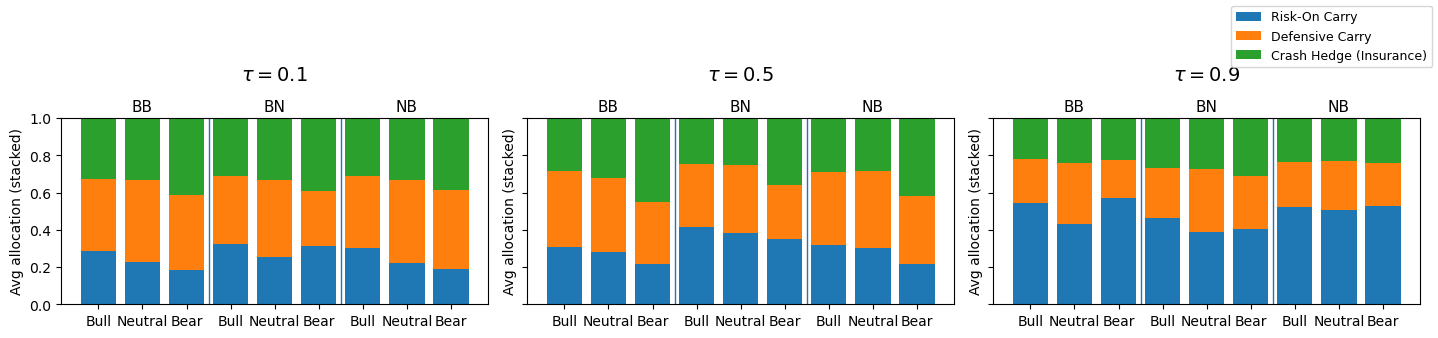

In [15]:


def _iter_payloads_for_tau(nested_scenario, tau_str):
    # load the target tau policy and by train and 
    # test seed to get the desired variable of interest
    if tau_str not in nested_scenario:
        return
    by_train = nested_scenario[tau_str]
    for _train_seed, by_test in by_train.items():
        if not isinstance(by_test, dict):
            continue
        for _test_seed, payload in by_test.items():
            if isinstance(payload, dict):
                yield payload


def avg_allocations_by_regime(nested_scenario, tau_str, weights_key="weights", regime_key="regime_days"):
    """
    Returns avg_w: (3, N) for regimes [Bull(0), Neutral(1), Bear(2)]
    averaging over all (train_seed, test_seed) paths and weighting by the number of days in regime.
    Monthly regimes with daily VAR-based returns, where everything is regime specific
    average weights given the regime.
    Note that the regime is the realized return regime not when the decision was made!!
    How do we know the ordering?: 

    """
    sum_w = None
    cnt = np.zeros(3, dtype=np.float64)

    for payload in _iter_payloads_for_tau(nested_scenario, tau_str):
        w = payload.get(weights_key, None) # if doesnt exist continue and return none
        k = payload.get(regime_key, None)
        if w is None or k is None:
            continue

        w = np.asarray(w, dtype=np.float64)
        k = np.asarray(k, dtype=int)

        T = min(len(k), w.shape[0])
        if T <= 1:
            continue

        # drop t=0 initial condition
        w = w[1:T]
        k = k[1:T]

        N = w.shape[1]
        if sum_w is None:
            sum_w = np.zeros((3, N), dtype=np.float64)
        # 0,1,2 regimes 
        for reg in (0, 1, 2):
            mask = (k == reg)
            c = int(mask.sum())
            if c == 0:
                continue
            sum_w[reg] += w[mask].sum(axis=0)
            cnt[reg] += c

    if sum_w is None:
        raise ValueError(f"No usable payloads found for tau={tau_str} (check keys/paths).")

    avg_w = sum_w / np.maximum(cnt[:, None], 1.0)
     # what was the average weight in each regime, 
    #averaged over all paths and weighted by the number of days in that regime across all paths
    # renormalize per regime
    avg_w = np.clip(avg_w, 0.0, np.inf)
    row_sums = avg_w.sum(axis=1)
    print("Row sums before renorm:", row_sums)
    avg_w /= np.maximum(avg_w.sum(axis=1, keepdims=True), 1e-12)
    return avg_w

# rename these
def plot_regime_allocations_panels(
    nested_by_scenario,
    tau_str_list=("01", "05", "09"),
    scenario_order=("BB", "BN", "NB"),
    regime_names=("Bull", "Neutral", "Bear"),
    #asset_names=("Asset 1", "Asset 2","Asset 3"),
    asset_names=("Risk-On Carry", "Defensive Carry", "Crash Hedge (Insurance)"),
    title_prefix="τ=",
        ):
 
    n_taus = len(tau_str_list)
    fig, axes = plt.subplots(1, n_taus, figsize=(4.8 * n_taus, 3.4), sharey=True)
    if n_taus == 1:
        axes = [axes]

    for ax, tau_str in zip(axes, tau_str_list):
        # build (9, N)
        blocks = []
        for scen in scenario_order:
            avg_w = avg_allocations_by_regime(nested_by_scenario[scen], tau_str)  # (3,N)
            # for each tau we go through per scenario and get the average weights by regime.
            blocks.append(avg_w)
        W = np.vstack(blocks)  # (9,N)

        N = W.shape[1]
        if N != len(asset_names):
            asset_names_plot = [f"Asset {i+1}" for i in range(N)]
        else:
            asset_names_plot = list(asset_names)

        x = np.arange(9)
        bottom = np.zeros(9, dtype=float)
        for j in range(N):
            ax.bar(x, W[:, j], bottom=bottom, width=0.8, label=asset_names_plot[j])
            bottom += W[:, j]

        ax.set_ylim(0, 1.0)

        tau_val = int(tau_str) / 10.0
        ax.text(
            0.5, 1.18, rf"$\tau={tau_val:.1f}$",
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=14, fontweight="bold"
        )

        ax.set_ylabel("Avg allocation (stacked)")

        # bottom labels: Bull/Neutral/Bear repeated
        ax.set_xticks(x)
        ax.set_xticklabels(list(regime_names) * 3)

        # vertical separators between scenario groups
        ax.axvline(2.5, linewidth=1)
        ax.axvline(5.5, linewidth=1)

        # top labels (scenario) centered over each group of 3 bars
        for scen, cx in zip(scenario_order, [1, 4, 7]):
            ax.text(
                cx, 1.02, scen,
                ha="center", va="bottom",
                transform=ax.get_xaxis_transform(),
                fontsize=11
            )

        ax.margins(y=0.12)

    # one legend for whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", frameon=True, fontsize=9)

    # leave extra top space so τ labels are not clipped
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()




nested_by_scenario = {
    "BB": nested_bull_bear,
    "BN": nested_bull_neutral,
    "NB": nested_neutral_bear,
}

plot_regime_allocations_panels(
    nested_by_scenario,
    tau_str_list=("01", "05", "09"),
    scenario_order=("BB", "BN", "NB"),
    regime_names=("Bull", "Neutral", "Bear"),
    asset_names=("Risk-On Carry", "Defensive Carry", "Crash Hedge (Insurance)"),
)


In [16]:
# Visit weighted metrics. Use the default table code

def weighted_group_mean(df: pd.DataFrame, group_cols, weight_col: str, metric_cols):
    d = df.copy()
    out = []
    # we will build the final result as "one dictionary per group", then convert to a DataFrame

    for keys, g in d.groupby(group_cols, dropna=False):
        gw = g[weight_col].astype(float).clip(lower=0)
        denom = gw.sum()

        if not isinstance(keys, tuple):
            keys = (keys,)
        row = dict(zip(group_cols, keys))
        row["N_paths"] = int(len(g)) # training seed x test seed paths 16 this case
        row["SumWeights"] = float(denom)

        for m in metric_cols:
            # now we compute the weighted mean for EACH metric (Sharpe, CVaR, etc.)

            vals = g[m].astype(float)
            row[m] = float((vals * gw).sum() / denom) if denom > 0 else np.nan

        out.append(row)

    return pd.DataFrame(out).sort_values(group_cols).reset_index(drop=True)


def unweighted_group_mean(df: pd.DataFrame, group_cols, metric_cols):
    agg = {m: "mean" for m in metric_cols}
    out = df.groupby(group_cols, as_index=False).agg(agg)
    out["N_paths"] = df.groupby(group_cols).size().values
    return out.sort_values(group_cols).reset_index(drop=True)



In [17]:

dfs_by_scenario = {"BB": nested_bull_bear, "BN": nested_bull_neutral, "NB": nested_neutral_bear}
REGIME_NAME = {0: "Bull", 1: "Neutral", 2: "Bear"}

path_df = summarize_path_metrics_paper_style(
    dfs_by_scenario,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95,
    use_key="port_ret_net",
    REGIME_NAME=REGIME_NAME)
'''
NOTE:
    Rp_net = max(Rp_gross - fee, 1e-8)

            # store in *simple return* for later Sharpe etc
            port_ret_gross[t] = Rp_gross - 1.0
            port_ret_net[t] = Rp_net - 1.0
'''
metric_cols = [
    "Ann. Mean (%)","Ann. StdDev (%)","Ann. SemiDev (%)",
    "CVaR 95% (%)","VaR 95% (%)","Avg DD (%)",
    "Sharpe (ann.)","Sortino (ann.)",
    "Tail-Adj Sharpe (CVaR95)","Tail-Adj Sharpe (mVaR95)"
]

# REGIME TABLES (Bull/Neutral/Bear), no ALL-regime
reg_only = path_df[path_df["Regime"].isin(["Bull","Neutral","Bear"])].copy()

#regime_unweighted = unweighted_group_mean(reg_only, group_cols=["Scenario","Tau","Regime"], metric_cols=metric_cols)

regime_weighted = weighted_group_mean(reg_only, group_cols=["Scenario","Tau","Regime"], weight_col="N_obs", metric_cols=metric_cols)

# OVERALL TABLES ("All") - i.e. aggregate over all regimes, by scenario and tau
#all_only = path_df[path_df["Regime"]=="All"].copy()
#overall_unweighted = unweighted_group_mean(all_only, group_cols=["Scenario","Tau"], metric_cols=metric_cols)
#overall_weighted = weighted_group_mean(all_only, group_cols=["Scenario","Tau"], weight_col="N_obs", metric_cols=metric_cols)
#  "NB only" (overall, by Tau) — weighted + unweighted under each other
#nb_all = all_only[all_only["Scenario"]=="NB"].copy()

#nb_weighted = weighted_group_mean(nb_all, group_cols=["Tau"], weight_col="N_obs",metric_cols=["VaR 95% (%)","CVaR 95% (%)","Ann. Mean (%)","Sharpe (ann.)",
#                 "Ann. StdDev (%)","Sortino (ann.)","Tail-Adj Sharpe (CVaR95)"])

#nb_unweighted = unweighted_group_mean(nb_all, group_cols=["Tau"],metric_cols=["VaR 95% (%)","CVaR 95% (%)","Ann. Mean (%)","Sharpe (ann.)",
#                 "Ann. StdDev (%)","Sortino (ann.)","Tail-Adj Sharpe (CVaR95)"])

#display(nb_unweighted)

# "Overall across scenarios" (All-regime, by Tau) — i.e. tau_01, tau_05, tau_09
#all_weighted_by_tau = weighted_group_mean(all_only, group_cols=["Tau"], weight_col="N_obs",metric_cols=["VaR 95% (%)","CVaR 95% (%)","Ann. Mean (%)","Sharpe (ann.)",
#                 "Ann. StdDev (%)","Sortino (ann.)","Tail-Adj Sharpe (CVaR95)"])

#all_unweighted_by_tau = unweighted_group_mean(
#    all_only, group_cols=["Tau"],
#    metric_cols=["VaR 95% (%)","CVaR 95% (%)","Ann. Mean (%)","Sharpe (ann.)",
#                 "Ann. StdDev (%)","Sortino (ann.)","Tail-Adj Sharpe (CVaR95)"])

In [18]:
path_df.head(10)

,Scenario,Tau,tau_str,TrainSeed,TestSeed,Regime,N_obs,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,tau_01,01,53,1,All,5040,9.298387,6.663920,6.949300,-0.987352,2.544766,-0.594084,1.395333,1.338032,9.417501,16.121613
1,BB,tau_01,01,53,1,Bull,3039,13.981721,6.105896,6.389474,-0.889709,1.536229,-0.534603,2.289872,2.188243,15.714933,28.164210
2,BB,tau_01,01,53,1,Neutral,372,8.688546,2.647515,2.915685,-0.398979,0.517196,-0.248248,3.281774,2.979933,21.776924,36.676815
3,BB,tau_01,01,53,1,Bear,1629,0.700603,8.110850,8.023013,-1.212993,5.704944,-0.742240,0.086378,0.087324,0.577582,0.905874
4,BB,tau_01,01,53,2,All,5040,33.923377,33.260497,19.546281,-2.669269,4.558890,-1.122633,1.019930,1.735541,12.708865,0.544535
5,BB,tau_01,01,53,2,Bull,2155,22.985785,25.536644,25.431668,-3.351533,4.501003,-1.270004,0.900110,0.903825,6.858290,310.470746
6,BB,tau_01,01,53,2,Neutral,760,36.676221,23.650745,16.013213,-2.263701,1.463872,-0.726444,1.550743,2.290372,16.201883,12.076260
7,BB,tau_01,01,53,2,Bear,2125,44.030836,41.970385,13.757643,-2.063459,5.107104,-1.095363,1.049093,3.200464,21.338358,0.523967
8,BB,tau_01,01,53,3,All,5040,9.115532,6.690435,6.523013,-0.972799,4.597147,-0.591318,1.362472,1.397442,9.370412,15.465576
9,BB,tau_01,01,53,3,Bull,2171,21.338237,7.148405,7.106419,-0.972443,1.509032,-0.586530,2.985035,3.002671,21.942911,36.057561


In [19]:
regime_weighted.head(10)

,Scenario,Tau,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),VaR 95% (%),Avg DD (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,tau_01,Bear,16,32036.0,25.724813,23.619213,14.974036,-2.346265,-1.292672,9.379348,0.611225,1.179226,7.654388,56.650497
1,BB,tau_01,Bull,16,38160.0,12.997626,10.163791,10.407755,-1.421113,-0.721024,3.193118,1.530331,1.495405,10.704287,39.530349
2,BB,tau_01,Neutral,16,10444.0,13.779490,11.427875,9.413642,-1.328651,-0.592709,2.553837,1.116824,1.316192,9.534575,11.157562
3,BB,tau_05,Bear,16,32036.0,26.039430,25.304810,15.851755,-2.488491,-1.343269,12.723877,0.492370,1.064279,6.967488,8.453862
4,BB,tau_05,Bull,16,38160.0,13.889882,10.298235,10.699616,-1.445599,-0.737359,3.085582,1.635984,1.587521,11.414840,58.997098
5,BB,tau_05,Neutral,16,10444.0,13.477745,12.003265,10.134885,-1.421163,-0.621780,2.710850,1.083861,1.241197,8.889115,11.305102
6,BB,tau_09,Bear,16,32036.0,5.541554,48.291668,36.205162,-5.913873,-3.182635,49.470579,-0.350538,-0.155951,-0.842565,-2.363949
7,BB,tau_09,Bull,16,38160.0,19.603944,12.679704,13.443705,-1.779544,-0.881949,3.810930,1.926568,1.855587,13.486674,46.800848
8,BB,tau_09,Neutral,16,10444.0,13.348600,14.492066,12.706012,-1.788519,-0.752263,3.801261,0.996553,1.072490,7.678658,10.714072
9,BN,tau_01,Bear,16,1464.0,-9.756456,9.348664,9.209692,-1.418048,-0.924398,5.272831,-2.201389,-1.762271,-12.601835,-15.694132


In [20]:
regime_weighted = weighted_group_mean(reg_only, group_cols=["Tau","Regime"], weight_col="N_obs", metric_cols=metric_cols)
display(regime_weighted)

,Tau,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),VaR 95% (%),Avg DD (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,tau_01,Bear,48,72852.0,22.166311,21.959013,14.327099,-2.245019,-1.223498,9.907916,0.523091,1.033627,6.659418,31.479786
1,tau_01,Bull,48,90672.0,12.515657,8.632177,8.883712,-1.240033,-0.660170,2.739615,1.763549,1.710950,12.341405,30.478233
2,tau_01,Neutral,48,78396.0,11.367843,11.783299,11.036501,-1.644254,-0.873364,4.818658,0.997781,1.061186,7.279356,13.568619
3,tau_05,Bear,48,72852.0,22.270755,23.490821,15.160145,-2.377016,-1.277884,13.262111,0.413940,0.923392,6.008491,6.244295
4,tau_05,Bull,48,90672.0,14.404997,8.983036,9.341203,-1.290335,-0.689115,2.656021,1.939033,1.872677,13.578037,40.589510
5,tau_05,Neutral,48,78396.0,11.723757,12.901776,12.227415,-1.818529,-0.964312,5.970934,0.971194,1.019547,6.984744,12.864170
6,tau_09,Bear,48,72852.0,3.856630,44.426421,33.616890,-5.489222,-2.940423,47.539302,-0.331692,-0.122451,-0.680450,-2.002542
7,tau_09,Bull,48,90672.0,17.589657,10.356538,10.874688,-1.484552,-0.776024,3.007257,2.091501,2.017117,14.683217,35.625901
8,tau_09,Neutral,48,78396.0,12.237402,14.486623,13.928013,-2.059892,-1.069016,6.848852,0.939385,0.966991,6.617144,12.846498
